<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr13/Practice13_ode2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import numpy as np 
import time
import pickle


from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_moons
from sklearn import metrics


from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats

from tqdm.notebook import tqdm, trange

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, SVHN
from torchvision.utils import make_grid

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# utils

In [ ]:
def make_scatterplot(points, title=None, filename=None):
    plt.figure()
    plt.scatter(points[:, 0], points[:, 1], s=1)
    if title is not None:
        plt.title(title)

In [ ]:
def load_half_moons(n):
    return make_moons(n_samples=n, noise=0.1)

In [ ]:
def load_smiley_face(n):
    count = n
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
              -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [ ]:
def q1_sample_data_1():
    train_data, train_labels = load_smiley_face(2000)
    test_data, test_labels = load_smiley_face(1000)
    return train_data, train_labels, test_data, test_labels

In [ ]:
def visualize_q1_data(dset_type):
    if dset_type == 1:
        train_data, train_labels, test_data, test_labels = q1_sample_data_1()
    elif dset_type == 2:
        train_data, train_labels, test_data, test_labels = q1_sample_data_2()
    else:
        raise Exception('Invalid dset_type:', dset_type)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 4.8))
    ax1.set_title('Train Data')
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.set_xlabel('x1')
    ax1.set_xlabel('x2')
    ax2.set_title('Test Data')
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax1.set_xlabel('x1')
    ax1.set_xlabel('x2')
    print(f'Dataset {dset_type}')
    plt.show()

def show_2d_samples(samples, title='Samples'):
    plt.figure()
    plt.title(title)
    plt.scatter(samples[:, 0], samples[:, 1], s=1)
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show()

def show_2d_latents(latents, labels, title='Latent Space'):
    plt.figure()
    plt.title(title)
    plt.scatter(latents[:, 0], latents[:, 1], s=1, c=labels)
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.show()

def show_2d_densities(densities, dset_type, title='Densities'):
    plt.figure()
    plt.title(title)
    dx, dy = 0.025, 0.025
    if dset_type == 1: # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_type == 2: # moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    else:
        raise Exception('Invalid dset_type:', dset_type)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    # mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    # densities = np.exp(ptu.get_numpy(self.log_prob(mesh_xs)))
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()

In [ ]:
def plot_training(losses, title='Losses'):
    plt.figure()
    x = np.arange(len(losses))

    plt.plot(x, losses, label='loss')

    plt.legend()
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
def fit(model, train_data, bs=256, num_epochs=250, lr=1e-3):
    train_loader = data.DataLoader(train_data, batch_size=bs, shuffle=True)
    optim = opt.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in trange(num_epochs):
        for batch in train_loader:
            loss = model.loss(batch.float())

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.item())
        
    return losses

In [ ]:
def generate_data(n):
    gaussian1 = np.random.normal(loc=-0.5, scale=0.25, size=(n, 2))
    gaussian2 = np.random.normal(loc=1, scale=1, size=(n, 2))
    return gaussian1, gaussian2

In [ ]:
class DataGenerator:
    def __init__(self, mu1=-0.5, mu2=1, sig1=0.25, sig2=1):
        self.dist1 = norm(loc=mu1, scale=sig1)
        self.dist2 = norm(loc=mu2, scale=sig2)
    
    def sample(self, n):
        return self.dist1.rvs((n, 2)), self.dist2.rvs((n, 2))
    
    def dre(self, x):
        return self.dist1.pdf(x).sum(axis=-1) / self.dist2.pdf(x).sum(axis=-1)
    
    def plot(self):
        x1, x2 = self.sample(1000)
        x = np.vstack((x1, x2))
        y = np.hstack((np.ones(len(x1)), np.zeros(len(x2))))

        plt.title('Train Data')
        plt.scatter(x[:, 0], x[:, 1], s=10, c=y)
        plt.xlabel('x1')
        plt.xlabel('x2')
        plt.show()

In [ ]:
def mse_loss(real, est, data_nu, data_de):
    r_nu_est = est.dre(data_nu)
    r_de_est = est.dre(data_de)

    r_nu_true = real.dre(data_nu)
    r_de_true = real.dre(data_de)

    return (((r_nu_est - r_nu_true) ** 2).mean() + ((r_de_est - r_de_true) ** 2).mean()) / 2

In [ ]:
class SSdataset:
    def __init__(self, dataset, l=100):
        self.data, self.y = dataset
        self.l = l
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        if i < self.l:
            s = 1
        else:
            s = 0
        return self.data[i], self.y[i], s

# Example 1. RealNVP on 2d data

[RealNVP](https://arxiv.org/pdf/1605.08803.pdf)


- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters. The latent space should be $z \sim \mathcal N (0, I_2)$.


In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, type, n_hidden=2, hidden_size=256):
        super().__init__()

        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

        self.mlp = nn.Sequential(nn.Linear(2, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, hidden_size), 
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, 2))

    def build_mask(self, type):
        if type == "left":
            mask = torch.FloatTensor([1.0, 0.0])
        elif type == "right":
            mask = torch.FloatTensor([0.0, 1.0])
        return mask

    def forward(self, x, reverse=False):
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1)
        x_ = x * mask

        log_s, t = self.mlp(x_).split(1, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse: 
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, 
                 transforms):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.transforms = nn.ModuleList(transforms)
        
    def flow(self, x):
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z)

    def loss(self, x):
        return - self.log_prob(x).mean()
    
    def show_densities(self):
        dx, dy = 0.025, 0.025

        x_lim = (-4, 4)
        y_lim = (-4, 4)

        y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                        slice(x_lim[0], x_lim[1] + dx, dx)]

        mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
        densities = np.exp((self.log_prob(mesh_xs)).cpu().detach().numpy())
        show_2d_densities(densities, 1)
        
    def show_latents(self, train_data, train_labels):
        z, _ = self.flow(torch.FloatTensor(train_data))
        latents = z.cpu().detach().numpy()
        show_2d_latents(latents, train_labels)

In [ ]:
train_data, train_labels, _, _ = q1_sample_data_1()

Dataset 1


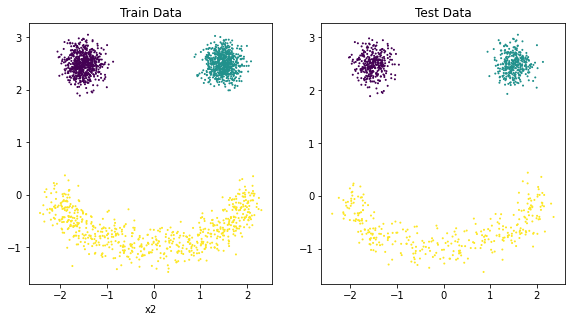

In [ ]:
visualize_q1_data(dset_type=1)

In [ ]:
real_nvp = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)])

In [ ]:
losses = fit(real_nvp, train_data)

  0%|          | 0/250 [00:00<?, ?it/s]

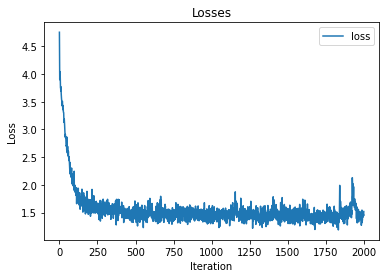

In [ ]:
plot_training(losses)

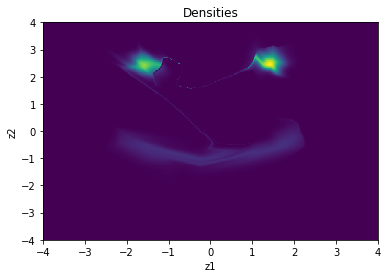

In [ ]:
real_nvp.show_densities()

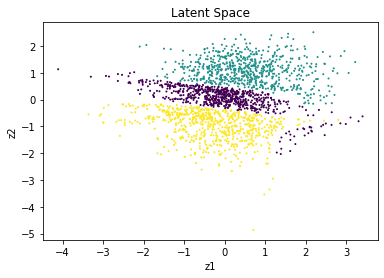

In [ ]:
real_nvp.show_latents(train_data, train_labels)

# Example 2. Homework

### squeeze

[RealNVP](https://arxiv.org/pdf/1605.08803.pdf)

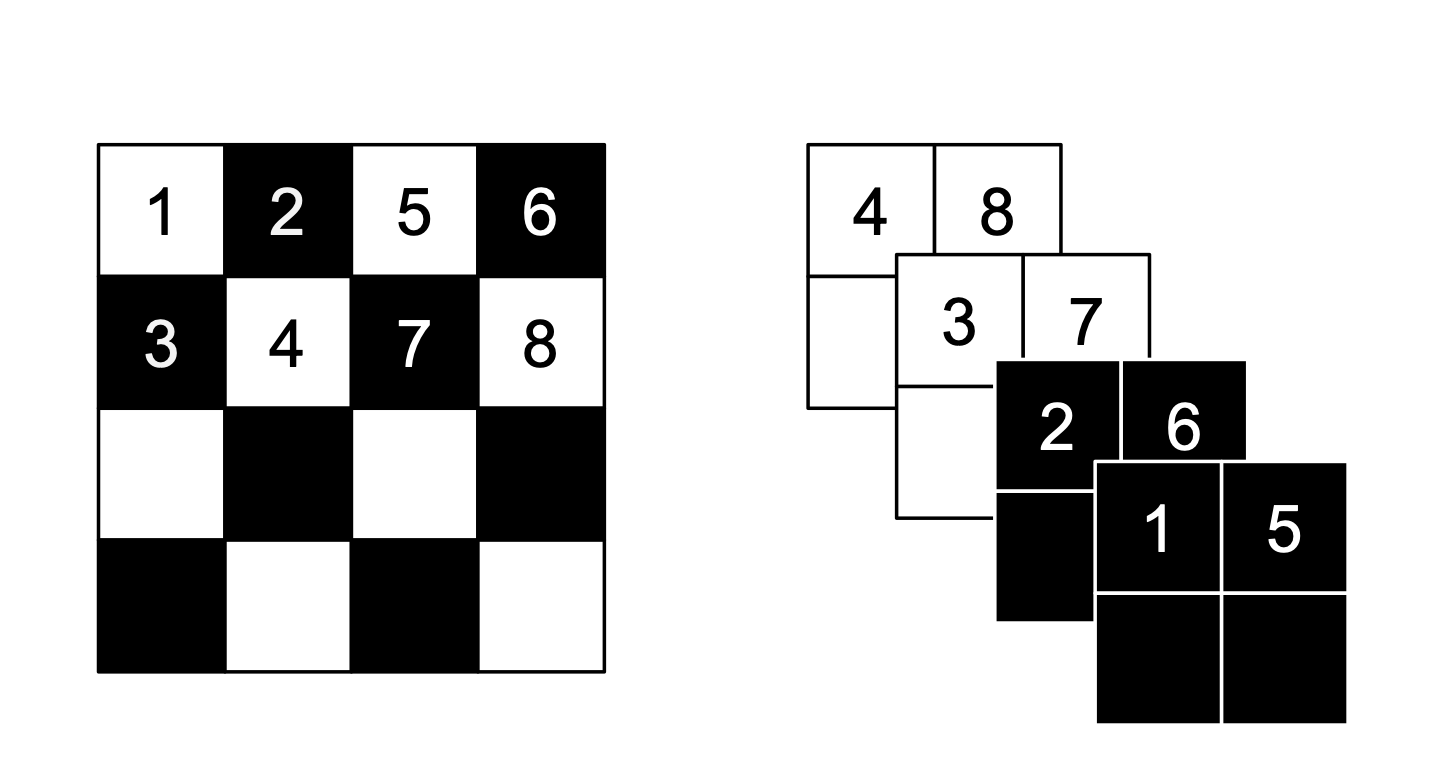

In [5]:
x = np.array([[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 14, 15], [12, 13, 16, 17]]).reshape(1, 4, 4)
x

array([[[ 1,  2,  5,  6],
        [ 3,  4,  7,  8],
        [ 9, 10, 14, 15],
        [12, 13, 16, 17]]])

In [12]:
x.reshape(4, 2, 2)

array([[[ 1,  2],
        [ 5,  6]],

       [[ 3,  4],
        [ 7,  8]],

       [[ 9, 10],
        [14, 15]],

       [[12, 13],
        [16, 17]]])

In [6]:
def squeeze(x):
    # C x H x W -> 4C x H/2 x W/2
    C, H, W = x.shape
    x = x.reshape(C, H, W // 2, 2) # redundant
    x = x.reshape(C, H // 2, 2, W // 2, 2)
    x = x.transpose(0, 2, 4, 1, 3)
    x = x.reshape(C * 4, H // 2, W // 2)
    return x

In [7]:
xs = squeeze(x)

In [8]:
xs

array([[[ 1,  5],
        [ 9, 14]],

       [[ 2,  6],
        [10, 15]],

       [[ 3,  7],
        [12, 16]],

       [[ 4,  8],
        [13, 17]]])

### act norm

[Glow](https://arxiv.org/pdf/1807.03039.pdf)

In [ ]:
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x):
        if not self.initialized:
            self.log_scale.data =  - torch.log(torch.std(x, dim=[0, 2, 3])).reshape(1, self.n_channels, 1, 1)
            self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True) * torch.exp(self.log_scale.data)
            self.initialized = True
            
        return x * torch.exp(self.log_scale) + self.shift, self.log_scale
    
    def reverse(self, z):
        raise NotImplementedError()

In [ ]:
x = torch.rand(128, 3, 32, 32)
actnorm = ActNorm(3)
ax, _ = actnorm(x)

In [ ]:
torch.mean(ax, dim=[0, 2, 3]).data, torch.std(ax, dim=[0, 2, 3]).data

(tensor([ 1.8612e-07, -7.3487e-08, -4.0018e-07]), tensor([1., 1., 1.]))

# Example 3. OOD

[paper1](https://arxiv.org/pdf/2006.08545.pdf), [paper2](http://proceedings.mlr.press/v139/zhang21g/zhang21g.pdf)

## results

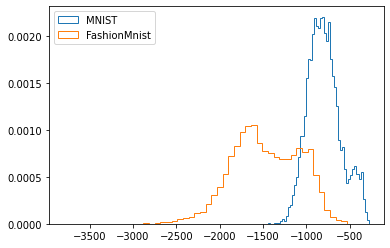

In [ ]:
#log prob distribution

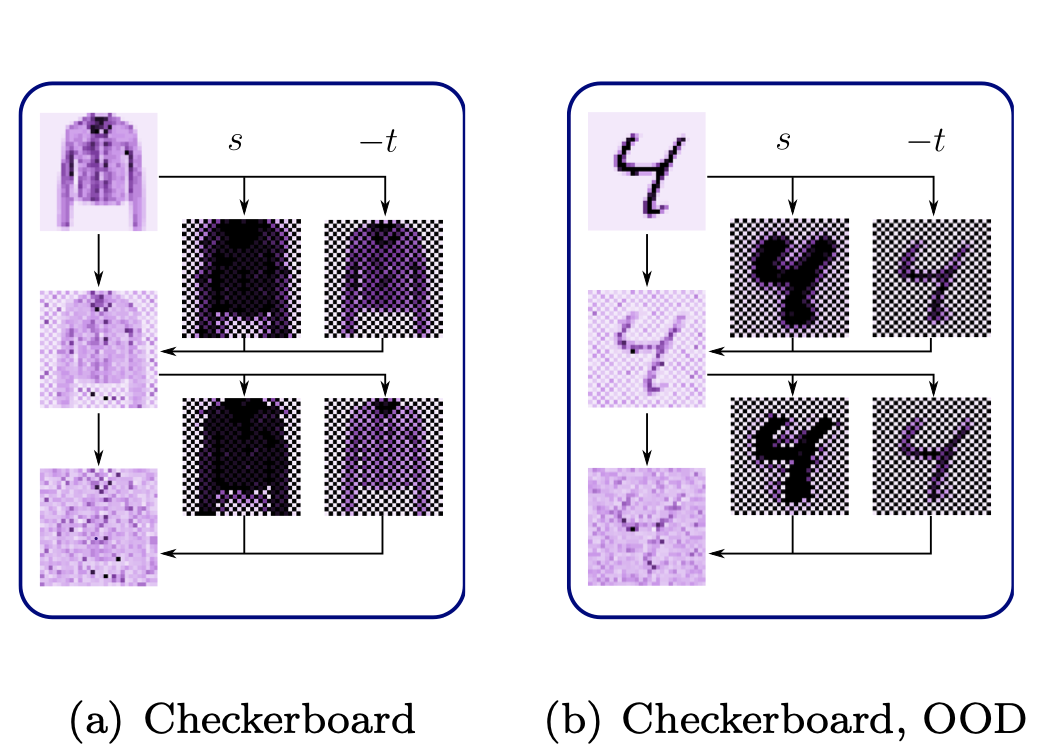

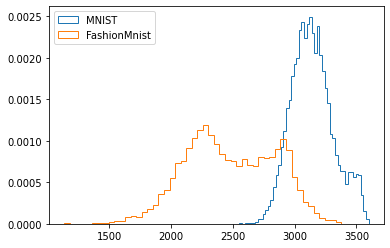

In [ ]:
# only logdet

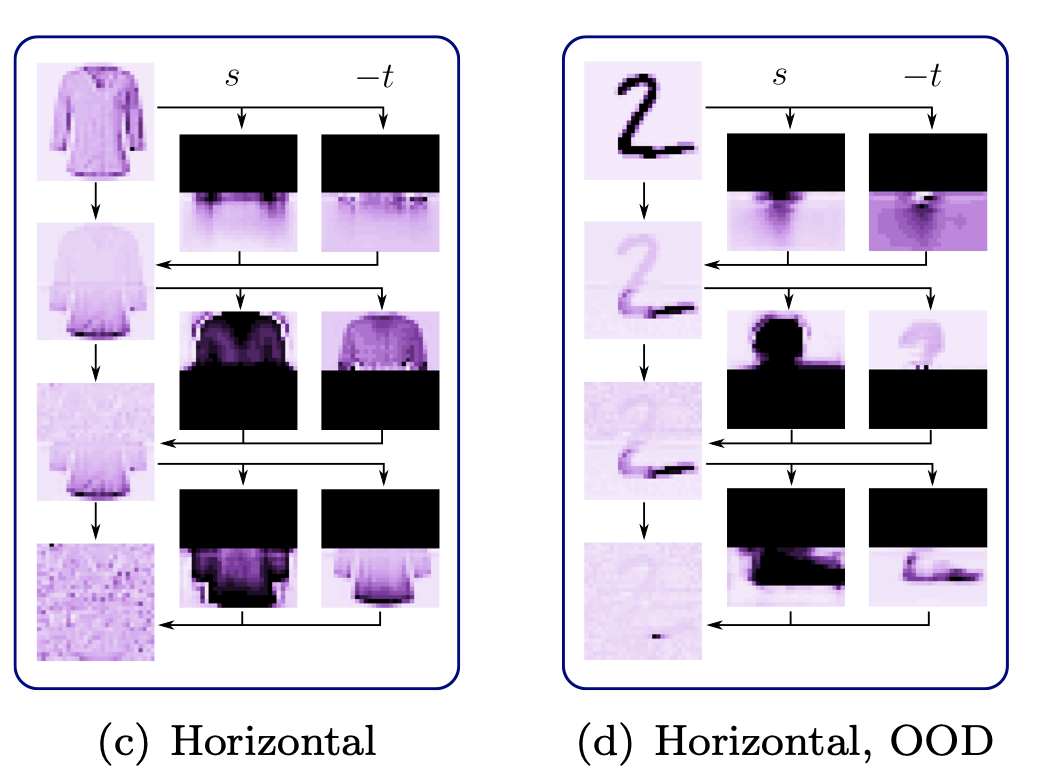

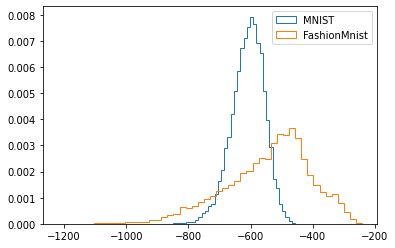

In [ ]:
#log prob distribution

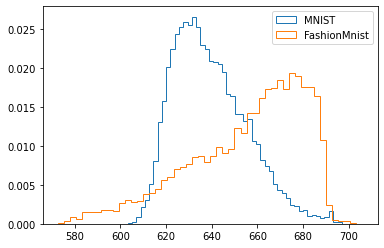

In [ ]:
# only logdet

**cycle mask**

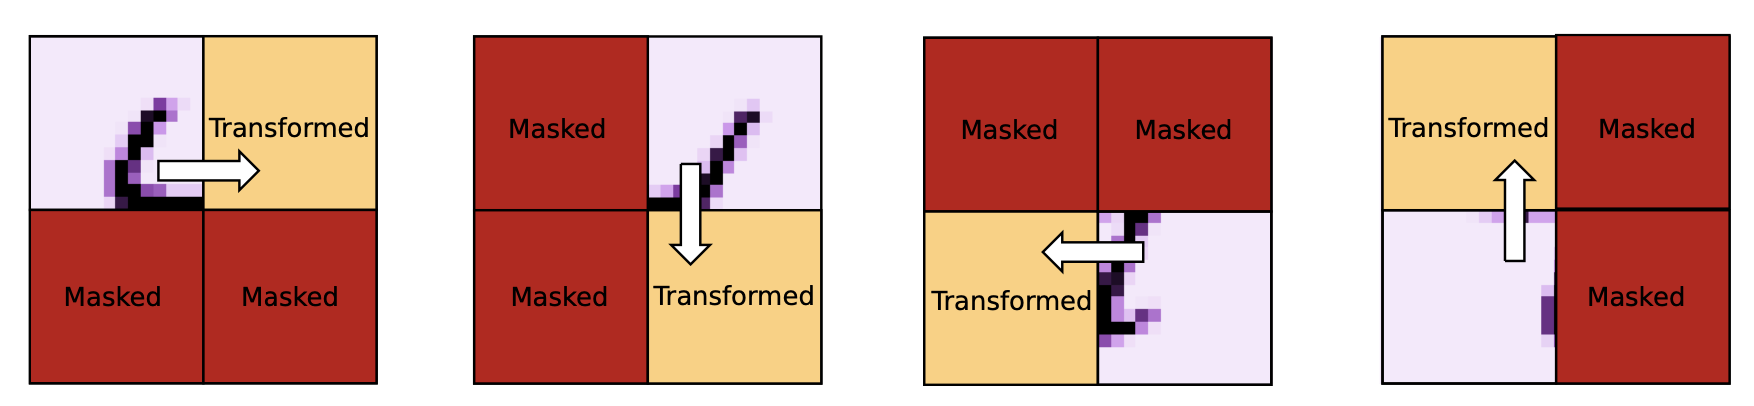

**what did it cost?**

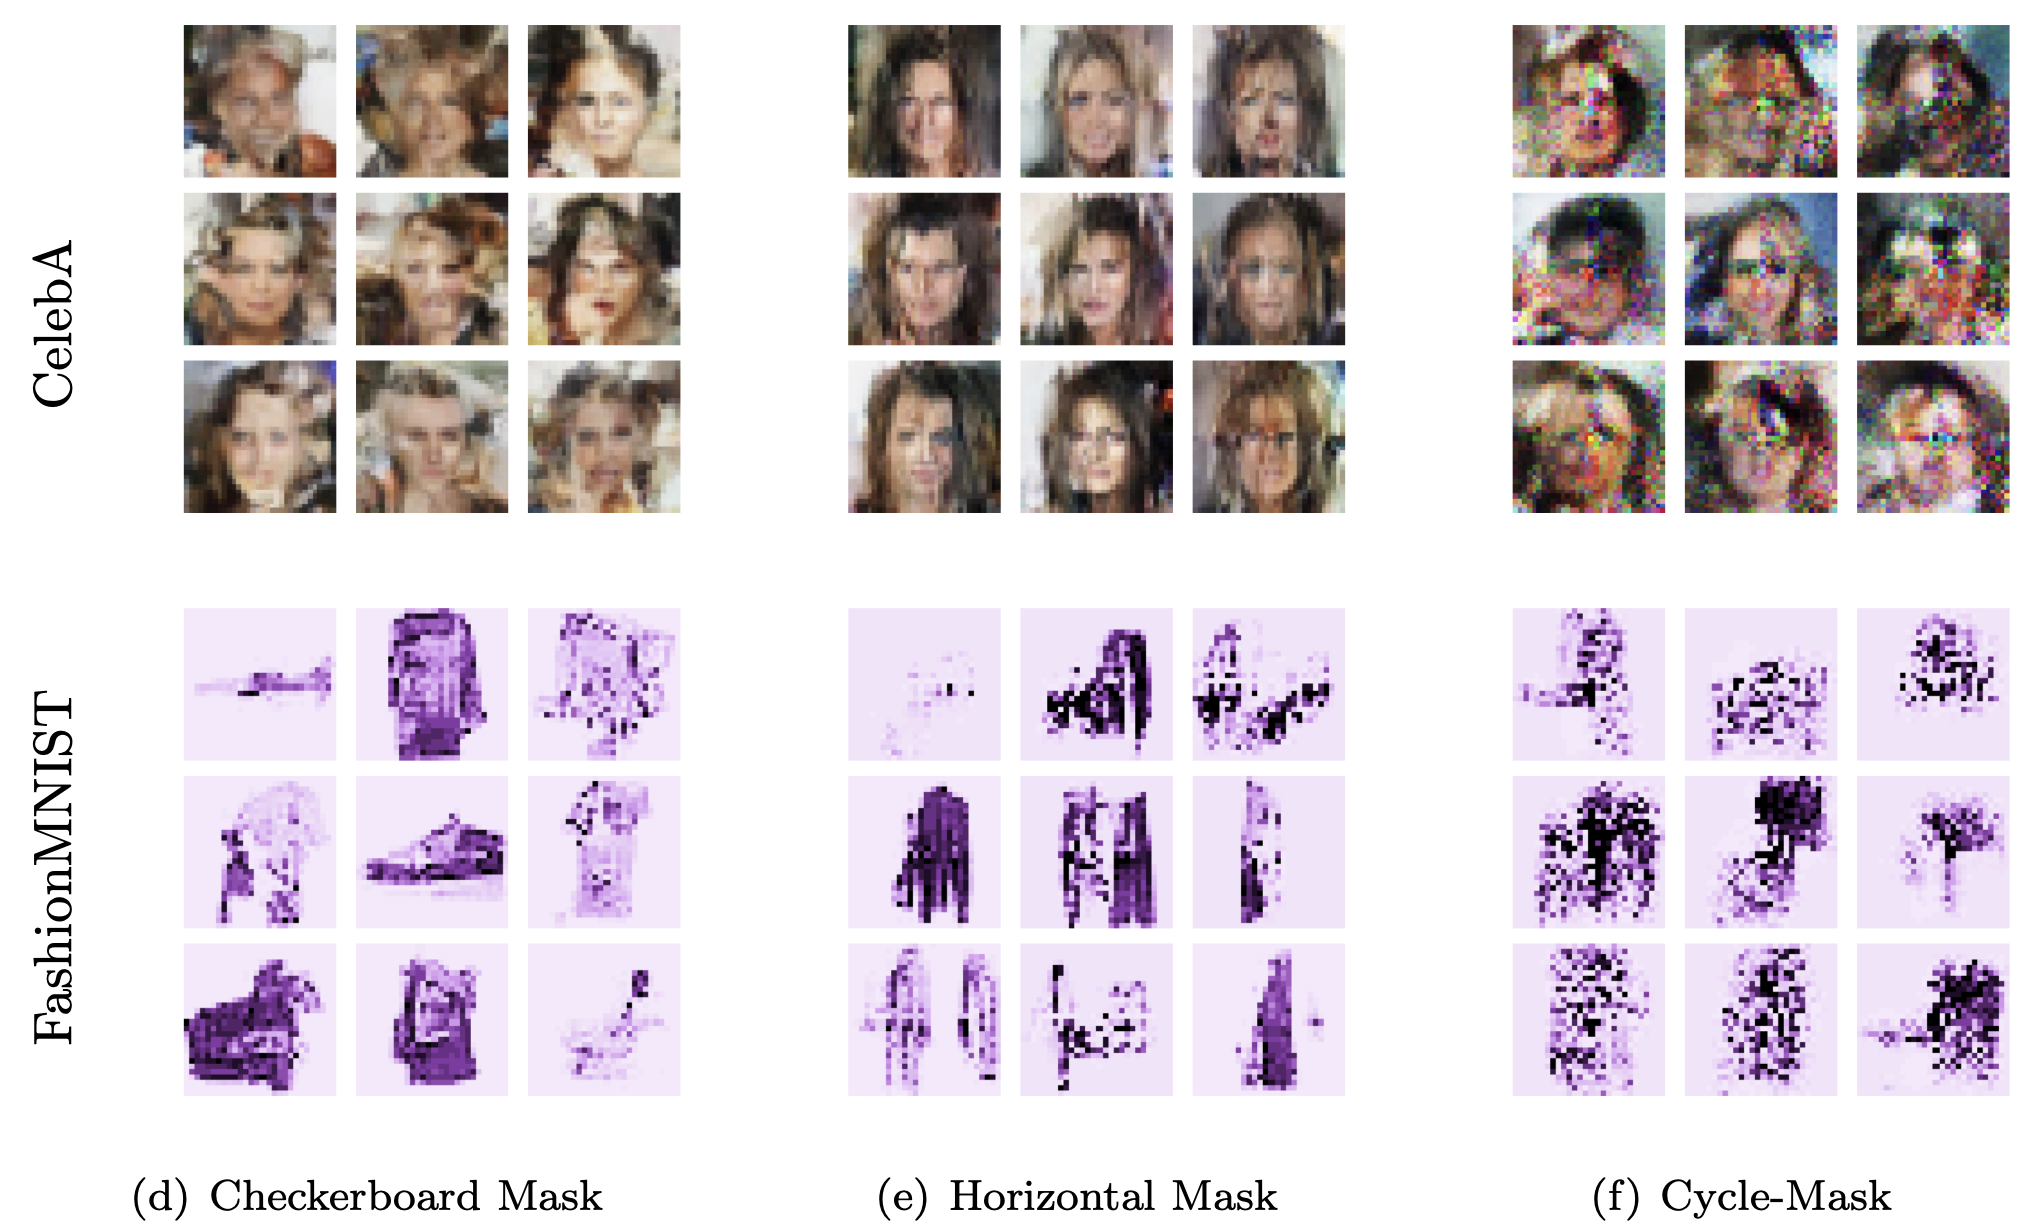

# Example 4. DRE

[paper](https://arxiv.org/pdf/2107.02212.pdf)

In [ ]:
dg = DataGenerator()

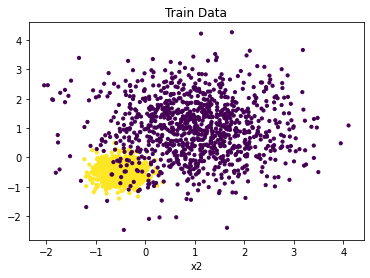

In [ ]:
dg.plot()

In [ ]:
)

In [ ]:
class MeanMatchDRE(nn.Module):
    def __init__(self, hd=128):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(2, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
    
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
     
        loader_nu = data.DataLoader(data_nu, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        
        loader_de = data.DataLoader(data_de, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        

        optim = opt.Adam(self.r.parameters(), lr=lr)


        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 2).float()
                batch_de = batch_de.view(-1, 2).float()

                loss = (((self.r(batch_de) * batch_de).mean(dim=0) - batch_nu.mean(dim=0)) ** 2).sum()

                optim.zero_grad()
                loss.backward()
                optim.step()
        
    def dre(self, dataset):
        dataloader = data.DataLoader(dataset, batch_size=200, shuffle=False)
        y_pred = []

        for x in dataloader:
            x = x.to(device).float()
            res = self.r(x.to(device).float())
            y_pred.append(res.squeeze().detach().cpu().numpy())
        y_pred = np.hstack(y_pred)
        return y_pred

In [ ]:
data_nu_train, data_de_train = dg.sample(5000)

In [ ]:
model = MeanMatchDRE()
model.fit(data_nu_train, data_de_train)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
mse_loss(dg, model, data_nu_test, data_de_test)

355.75981535972284

## training a flow

In [ ]:
real_nvp = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)])

In [ ]:
_ = fit(real_nvp, np.vstack((data_nu_train, data_de_train)))

  0%|          | 0/250 [00:00<?, ?it/s]

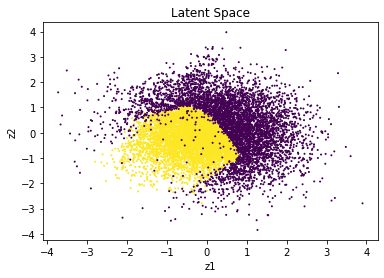

In [ ]:
real_nvp.show_latents(latents, np.hstack((np.ones(len(data_nu_train)), np.zeros(len(data_de_train)))))

In [ ]:
z, _ = real_nvp.flow(torch.FloatTensor(np.vstack((data_nu_train, data_de_train))))
latents = z.cpu().detach().numpy()
data_nu_flow, data_de_flow = latents[:5000], latents[5000:]

In [ ]:
dreflow = MeanMatchDRE()
dreflow.fit(data_nu_flow, data_de_flow)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
z, _ = real_nvp.flow(torch.FloatTensor(np.vstack((data_nu_test, data_de_test))))
latents = z.cpu().detach().numpy()
data_nu_flow, data_de_flow = latents[:5000], latents[5000:]


mse_loss(dg, model, data_nu_flow, data_de_flow)

111.16820947222077

# Example 5. Semi-supervised flow

[paper1](https://arxiv.org/pdf/1912.13025.pdf), [paper2](https://arxiv.org/pdf/1905.00505.pdf)

In [ ]:
class SSRealNVP(nn.Module):
    def __init__(self, 
                 transforms):
        super().__init__()

        self.prior = [torch.distributions.Normal(torch.tensor(0.0).to(device), torch.tensor(1.).to(device)), 
                      torch.distributions.Normal(torch.tensor(1).to(device), torch.tensor(1.).to(device))]
        self.transforms = nn.ModuleList(transforms)
        
    def flow(self, x):
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x, y, s):
        z, log_det = self.flow(x)


        prob0 = torch.sum(self.prior[0].log_prob(z), dim=1).view(-1, 1)
        prob1 = torch.sum(self.prior[1].log_prob(z), dim=1).view(-1, 1)

        prob = torch.hstack((prob0, prob1))

        y_lab = y[s==1]
        prob_lab = prob[s==1, :]
        prob_lab = prob_lab[torch.arange(len(y_lab)), y_lab]

        prob_unl = prob[s==0, :]
        prob_unl = torch.logsumexp(prob_unl, dim=1)

        prob = torch.hstack((prob_lab, prob_unl))


        return torch.sum(log_det, dim=1) + prob
    
    def clf(self, dataset):
        dataloader = data.DataLoader(dataset, batch_size=200, shuffle=False)
        y_pred = []

        for (x, _, _) in dataloader:
            x = x.to(device).float()
            z, log_det = self.flow(x)

            prob0 = torch.sum(self.prior[0].log_prob(z), dim=1).view(-1, 1)
            prob1 = torch.sum(self.prior[1].log_prob(z), dim=1).view(-1, 1)

            res =  torch.softmax(torch.hstack((prob0, prob1)), dim=1)[:, 1]
            y_pred.append(res.squeeze().detach().cpu().numpy())
        y_pred = np.hstack(y_pred)
        return y_pred
   
    def nll(self, x, y, s):
        return - self.log_prob(x, y, s).mean()

In [ ]:
a = torch.rand(100, 2)

In [ ]:
a[a[:, 0] < 0.5, :]

In [ ]:
train_data = SSdataset(make_moons(5000), 500)
test_data = SSdataset(make_moons(1000))

In [ ]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)

In [ ]:
real_nvp = SSRealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)])

In [ ]:
num_epochs = 250
lr = 5e-3

In [ ]:
optim = opt.Adam(real_nvp.parameters(), lr=lr)

In [ ]:
losses = []
for epoch in trange(num_epochs):
    for (x, y, s) in train_loader:

        loss = real_nvp.nll(x.float(), y, s)
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
preds = real_nvp.clf(test_data)

In [ ]:
metrics.roc_auc_score(test_data.y, preds)

0.942956